# Modelling

### Import libraries and modules

In [1]:
import pandas as pd
import numpy as np

from utils.classification_report import plot_feature_importance, plot_confusion_matrix, plot_ROC_curve

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import classification_report

### Load pre-processed data

In [2]:
# load data
df = pd.read_pickle('data/output/entities_processed_and_cleaned.pkl')

## RandomForest

As a first approach, we will use a Random Forest model, a powerful ensemble learning method that operates by constructing multiple decision trees during training and outputting the class that is the mode of the classes or mean prediction of the individual trees.

For preprocessing, categorical variables will be handled using OrdinalEncoder, which converts each string value to a whole number.
For numerical variables, we will standardize them to have a mean of 0 and a standard deviation of 1.
This preprocessing will ensure that our data is in the right format and ready for modeling.

Later on, we'll use a tokenizer for text data, which breaks down text into individual words or terms, making it understandable for machine learning models. Following tokenization, we'll apply an embedding. This transforms the tokenized words into vectors of real numbers, capturing semantic relationships between words. This numerical representation allows machine learning models to perform computations on the text data, enhancing their ability to understand and generate predictions.

In [3]:
# define X and y for the model, encode y as binary
X = df.drop(columns=['surname_household'])
y = df['surname_household'].apply(lambda x: 0 if pd.isna(x) else 1)

In [4]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# check the shape of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20059, 11), (5015, 11), (20059,), (5015,))

In [5]:
# check the distribution of the target variable in the training and testing sets
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(surname_household
 0    0.773269
 1    0.226731
 Name: proportion, dtype: float64,
 surname_household
 0    0.783051
 1    0.216949
 Name: proportion, dtype: float64)

In [6]:
# define a pipeline for the Random Forest model

# define the preprocessing steps for the model
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')) # mean imputation for missing values
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), # constant imputation for missing values
    # ordinal encoding for categorical variables
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value',
                               unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# define the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# fit the model on the training data
model.fit(X_train, y_train)

# make predictions on the testing data
y_pred = model.predict(X_test)

# evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3927
           1       0.98      0.99      0.99      1088

    accuracy                           0.99      5015
   macro avg       0.99      0.99      0.99      5015
weighted avg       0.99      0.99      0.99      5015



### Model summary

In [7]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['age', 'birth_date'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  Index(['surname', 'firstname', 'occupation', 'civil_status', 'nationality',
       'link', 'lob', 'employer', 'observation'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier())])

### Confusion matrix

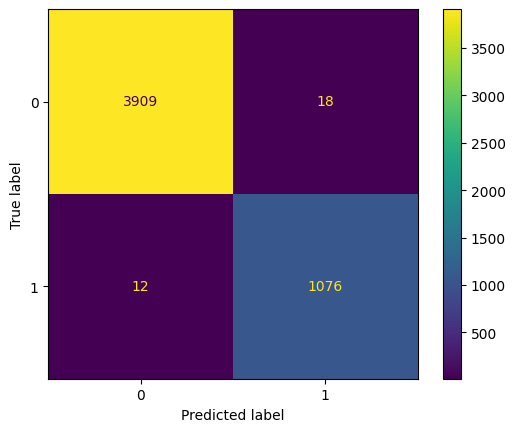

In [8]:
plot_confusion_matrix(model, y_pred=y_pred, y_test=y_test)

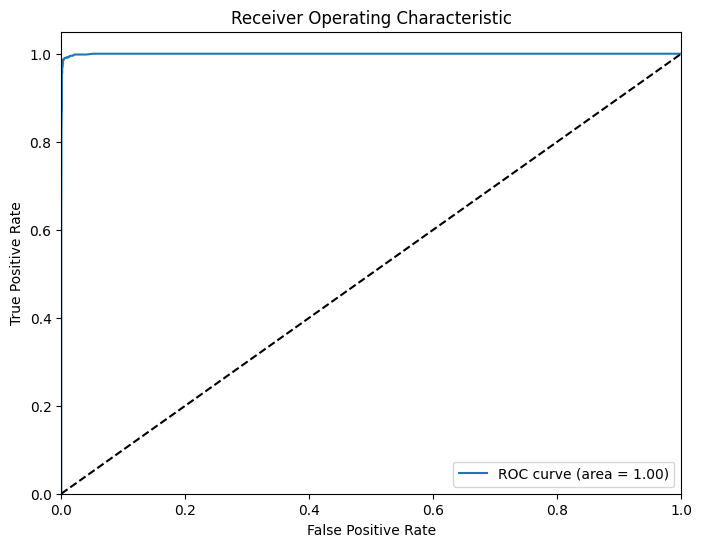

In [9]:
# ROC curve
plot_ROC_curve(model, X_test, y_test)

### Feature importance

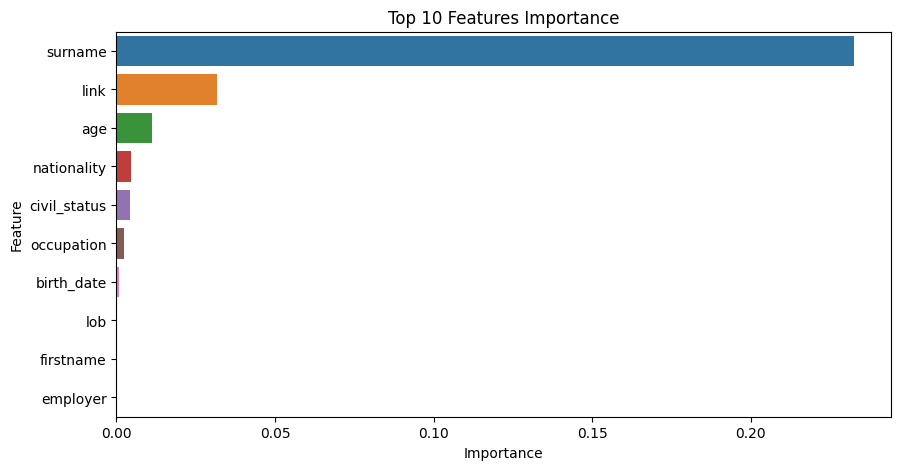

In [10]:
plot_feature_importance(model, X_test, y_test)

### Removing the `surname` column

The reason for removing the `surname` column is that it contains information that could potentially lead to "cheating" in the prediction process. Since people who are not part of a household have their name written in this column, using it as a feature could make the prediction task too easy and not reflect the true nature of the problem you are trying to solve.

By removing the `surname` column, we ensure that the prediction model focuses on other relevant features and avoids any bias or unfair advantage that could arise from using the latter column.

In [11]:
# now we make the same process but without the 'surname' column
X = df.drop(columns=['surname', 'surname_household'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# define the preprocessing steps for the model
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value',
                               unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# define the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# fit the model on the training data
model.fit(X_train, y_train)

# make predictions on the testing data
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      3927
           1       0.81      0.89      0.84      1088

    accuracy                           0.93      5015
   macro avg       0.89      0.91      0.90      5015
weighted avg       0.93      0.93      0.93      5015



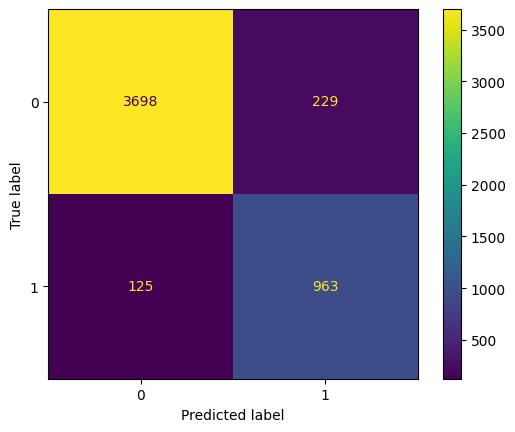

In [13]:
# plot confusion matrix
plot_confusion_matrix(model, y_pred=y_pred, y_test=y_test)

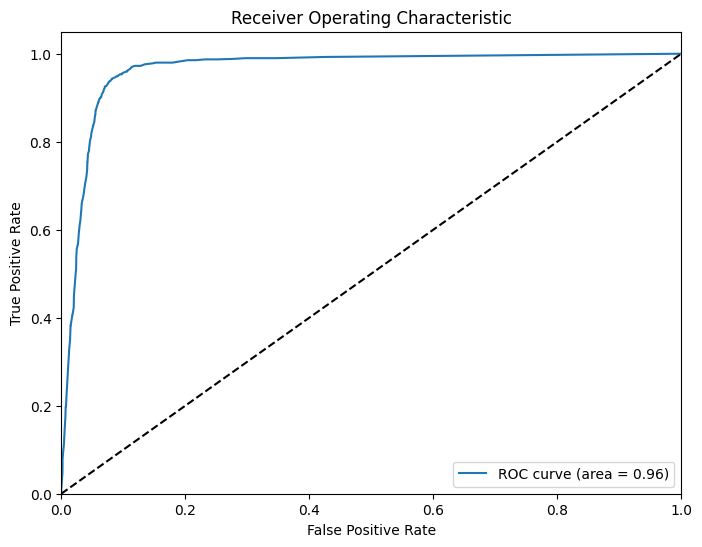

In [14]:
# ROC curve
plot_ROC_curve(model, X_test, y_test)

As expected, removing the 'surname' column from the model has a negative impact on the model performance.
However, has discussed earlier, it is more realistic to build a model without the 'surname' column.

In [15]:
model.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('imputer', SimpleImputer())]),
                                    Index(['age', 'birth_date'], dtype='object')),
                                   ('cat',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(fill_value='missing',
                                                                   strategy='constant')),
                                                    ('ordinal',
                                                     OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                    unknown_value=-1))]),
                                    Index(['firstname', 'occupation', 'civil_status', 'nationality', 'link', 'lob',
          'employer', 'observation'],
         dtype='object'))])),
  ('classifier', 

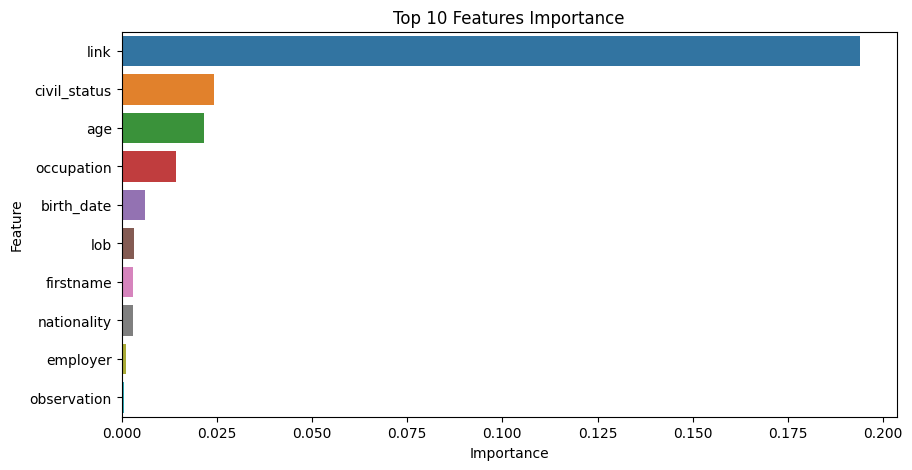

In [16]:
# calculate the feature importance using permutation importance
plot_feature_importance(model, X_test, y_test)

## Hyperparameter tuning

We will use RandomizedSearchCV for hyperparameter tuning. This method randomly selects combinations of hyperparameters from a defined grid, fits the model for each, and identifies the best performing set. It's more efficient than GridSearchCV, which tries all combinations. The best parameters will be used to fit our model on the training data

In [17]:
# use random search to find the best hyperparameters for the model

# define the hyperparameters grid
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_features': ['auto', 'sqrt'],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_split': [2, 3, None],
    'classifier__min_samples_leaf': [1, 2],
}

# define the RandomizedSearchCV
search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# fit the model on the training data
search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END classifier__max_depth=5, classifier__max_features=auto, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__max_depth=5, classifier__max_features=auto, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__max_depth=5, classifier__max_features=auto, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__max_depth=5, classifier__max_features=auto, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__max_depth=5, classifier__max_features=auto, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__max_depth=5, classifier__max_features=auto, classifier__min_samples_leaf=1, classifi

/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
240 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt, y, **l

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer())]),
                                                                               Index(['age', 'birth_date'], dtype='object')),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value='missing',
                                                                                                              strategy='constant')),
                                                                                               ('ordinal',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unk...
       'employer', 'observation'],
      dtype='object'))])),
                                             ('classifier',
                                              RandomForestClassifier())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'classifier__max_depth': [5, 10, None],
                                        'classifier__max_features': ['auto',
                                                                     'sqrt'],
                                        'classifier__min_samples_leaf': [1, 2],
                                        'classifier__min_samples_split': [2, 3,
                                                                          None],
                                        'classifier__n_estimators': [100, 200]},
                   random_state=42, verbose=2)

In [24]:
# get the best hyperparameters
search.best_params_

{'classifier__n_estimators': 200,
 'classifier__min_samples_split': 3,
 'classifier__min_samples_leaf': 2,
 'classifier__max_features': 'sqrt',
 'classifier__max_depth': None}

In [19]:
# make predictions on the testing data using the best model
y_pred = search.predict(X_test)

# evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96      3927
           1       0.80      0.91      0.85      1088

    accuracy                           0.93      5015
   macro avg       0.89      0.92      0.90      5015
weighted avg       0.94      0.93      0.93      5015



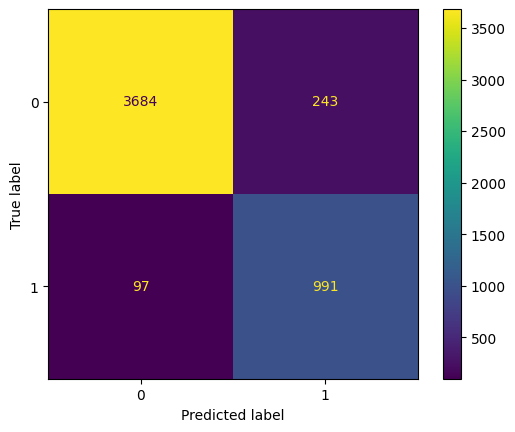

In [20]:
# plot confusion matrix
plot_confusion_matrix(search, y_pred=y_pred, y_test=y_test)

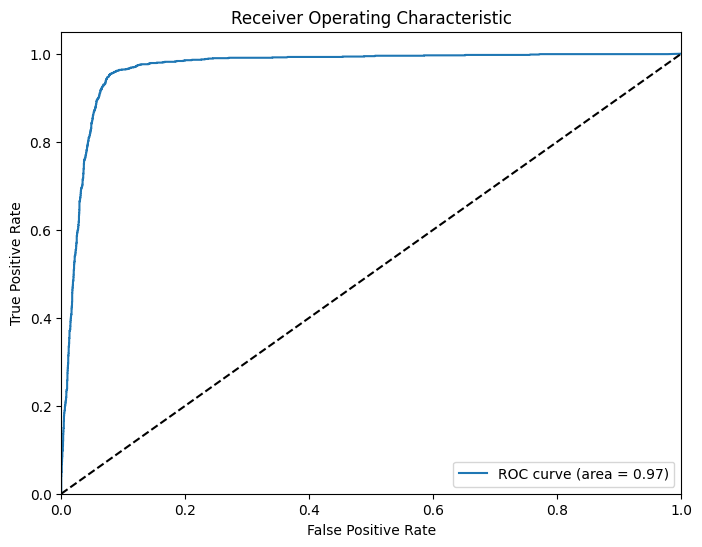

In [21]:
# roc curve
plot_ROC_curve(search, X_test, y_test)

The RandomizedSearchCV has slightly improved the model performance.

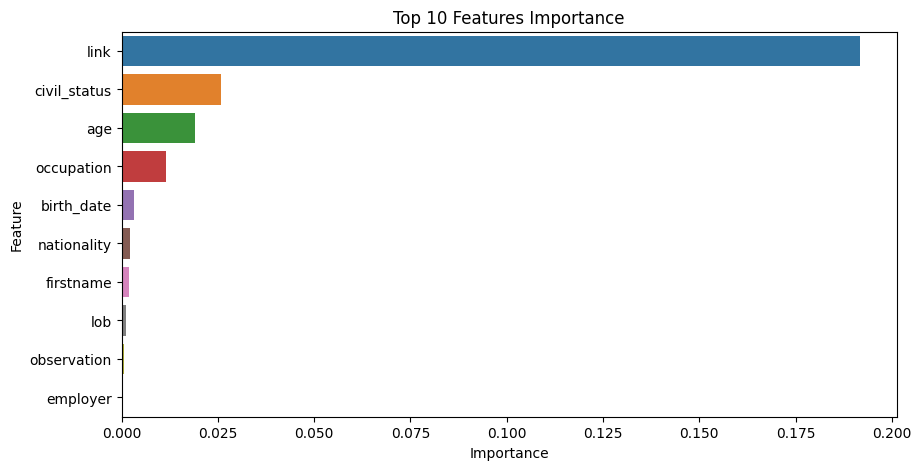

In [22]:
# calculate the feature importance
plot_feature_importance(search, X_test, y_test)

## Using Deep-Learning

In [5]:
# Import necessary libraries
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizerFast, BertForSequenceClassification
from torch.utils.data import DataLoader
import torch

# Load and preprocess the data
df.fillna('Unknown', inplace=True)

# Define the target variable
df['is_head'] = df['surname_household'].apply(lambda x: 1 if x == 'Unknown' else 0)

# Split the data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df['occupation'].values, df['is_head'].values, test_size=0.2)

# Prepare the data for text classification
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

# Convert our data into torch Dataset
class HouseholdDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = HouseholdDataset(train_encodings, train_labels)
test_dataset = HouseholdDataset(test_encodings, test_labels)

# Train a classifier
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = torch.optim.Adam(model.parameters(), lr=5e-5)

for epoch in range(3):
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 